# Main functions and programs

In [2]:
using Distributions, Random
using BenchmarkTools
using Plots
using StatsPlots
using LinearAlgebra # Used to calculate norms more succintly


const rng = Random.seed!(42);

# --------------------------------------------------------------------------------------------------------
# Running the simulation


function unit_cell(ρ::Float64, N::Int)
    n = cbrt(N/4)
    if n != trunc(Int, n)
        error("FCC lattice cannot be filled. Number of unit cells is not an integer.")
    end
    n = trunc(Int, n)
    a::Float64 = cbrt(4/ρ)
    L = n*a
    return n, a, L
end


function init_position(n::Int, a::Float64)
    positions = [Float64[x, y, z] for z=range(0, n-1) for y=range(0, n-1) for x=range(0, n-1)]
    append!(positions, [[j + 0.5, k + 0.5, l] for l=range(0,n-1) for k=range(0,n-1) for j=range(0,n-1)])
    append!(positions, [[j + 0.5, k, l + 0.5] for l=range(0,n-1) for k=range(0,n-1) for j=range(0,n-1)])
    append!(positions, [[j, k + 0.5, l + 0.5] for l=range(0,n-1) for k=range(0,n-1) for j=range(0,n-1)])
    for position in positions
        replace!(x -> max(x, 1e-8), position)  # Avoid having points exactly on the surface of the box.
    end
    return a*positions
end


function init_velocity(T::Float64, N::Int)
    μ, σ = 0., sqrt(T/48)
    velocities = rand(rng, Normal(μ, σ), (N, 3))
    average_velocities = vec(mean(velocities, dims=1))
    velocities = [velocities[i,:] - average_velocities for i in 1:size(velocities,1)]
    return velocities
end


function minimum_distance(particle::Array{Float64, 1}, agent::Array{Float64, 1}, L)
    Δ = particle - agent
    Δr_values_x = [Δ[1] + i for i=[0., L, -L]]
    Δr_values_y = [Δ[2] + i for i=[0., L, -L]]
    Δr_values_z = [Δ[3] + i for i=[0., L, -L]]
    Δr_values_x2 = Δr_values_x.^2
    Δr_values_y2 = Δr_values_y.^2
    Δr_values_z2 = Δr_values_z.^2
    Δr_x2 = minimum(Δr_values_x2)
    Δr_y2 = minimum(Δr_values_y2)
    Δr_z2 = minimum(Δr_values_z2)
    r2 = Δr_x2 + Δr_y2 + Δr_z2
    Δr_x = Δr_values_x[findfirst(isequal(Δr_x2), Δr_values_x2)]
    Δr_y = Δr_values_y[findfirst(isequal(Δr_y2), Δr_values_y2)]
    Δr_z = Δr_values_z[findfirst(isequal(Δr_z2), Δr_values_z2)]
    Δr = [Δr_x, Δr_y, Δr_z]
    return Δr, r2
end


function forces_vector_all(positions::Array{Array{Float64, 1}, 1}, L::Float64, r_v::Float64)
    N, = size(positions)
    forces = [Float64[0.,0.,0.] for _ in range(1, N)]
    
    for j in range(2, N)
        for i in range(1, j-1)
            Δr, r2 = minimum_distance(positions[i], positions[j], L)
            if r2 > r_v^2
                continue
            end
            force = Δr*((1/(r2^7)) - 0.5*(1/(r2^4)))
            forces[i] .+= force
            forces[j] .-= force
        end
    end
    return forces
end


function forces_and_book(positions::Array{Array{Float64, 1}, 1}, r_m::Float64, L::Float64, r_v::Float64)
    N, = size(positions)
    forces = [Float64[0.,0.,0.] for _ in range(1, N)]
    book = [Int[] for _ in range(1, N-1)]
    
    for j in range(2, N)
        for i in range(1, j-1)
            Δr, r2 = minimum_distance(positions[i], positions[j], L)
            if r2 > r_m^2
                continue
            end
            push!(book[i], j)
            if r2 > r_v^2
                continue
            end
            force = Δr*((1/(r2^7)) - 0.5*(1/(r2^4)))
            forces[i] .+= force
            forces[j] .-= force
        end
    end
    return forces, book
end


function forces_vector(positions::Array{Array{Float64, 1}, 1}, book::Array{Array{Int, 1}, 1}, L, r_v::Float64)
    N, = size(positions)
    forces = [Float64[0.,0.,0.] for _ in range(1, N)]
    
    for (i, table) in enumerate(book)
        for j in table
            Δr, r2 = minimum_distance(positions[i], positions[j], L)
            if r2 > r_v^2
                continue
            end
            force = Δr*((1/(r2^7)) - 0.5*(1/(r2^4)))
            forces[i] .+= force
            forces[j] .-= force
        end
    end
    return forces
end


function velocity_Verlet!(r, v, f, h, L, r_v)
    v_tilde = v + 0.5*h*f
    r[:] = r + h*v_tilde
    r[:] = [mod.(position, L) for position in r]  # Apply periodic boundary conditions
    f[:] = forces_vector_all(r, L, r_v)
    v[:] = v_tilde + 0.5*h*f
end


function velocity_Verlet!(r, v, f, h, L, r_v, book)
    v_tilde = v + 0.5*h*f
    r[:] = r + h*v_tilde
    r[:] = [mod.(position, L) for position in r]  # Apply periodic boundary conditions
    f[:] = forces_vector(r, book, L, r_v)
    v[:] = v_tilde + 0.5*h*f
end


function simulation(T, ρ, t_final, book_keeping, rescaling=false, r_v=2.5, h=0.032, N=864)
    if rescaling
       n_rescaling = 20 
    end
    
    # Initial configuration
    no_cells, a, L = unit_cell(ρ, N)
    steps = ceil(Int, t_final/h)
    positions = init_position(no_cells, a)
    velocities = init_velocity(T, N)
    
    position_history = [copy(positions)]
    velocity_history = [copy(velocities)]
    
    if book_keeping
        n = 16  # Update book every 'n' time steps
        r_m = 3.3  # Radius of neighbors considered
        
        forces, book = forces_and_book(positions, r_m, L, r_v)
    
        for step in range(1, steps)
            if mod(step, n) == 0
                forces, book = forces_and_book(positions, r_m, L, r_v)
            end
            velocity_Verlet!(positions, velocities, forces, h, L, r_v, book)
            if rescaling && mod(step, n_rescaling) == 0
                λ = sqrt(T/temperature(velocities))
                velocities *= λ
            end
            append!(position_history, [copy(positions)])
            append!(velocity_history, [copy(velocities)])
            
        end
    else
        forces = forces_vector_all(positions, L, r_v)
        
        for step in range(1, steps)
            velocity_Verlet!(positions, velocities, forces, h, L, r_v)
            if rescaling && mod(step, n_rescaling) == 0
                λ = sqrt(T/temperature(velocities))
                velocities *= λ
            end
            append!(position_history, [copy(positions)])
            append!(velocity_history, [copy(velocities)])
        end
    end
    
    return position_history, velocity_history
end

# --------------------------------------------------------------------------------------------------------



# --------------------------------------------------------------------------------------------------------
# Measurable quantities

function melting_factor(positions::Array{Array{Float64, 1}, 1}, ρ::Float64)
    a = cbrt(4/ρ)
    k = 4. *π/a
    positions_matrix = mapreduce(permutedims, vcat, positions)
    ρ_k = sum(cos.(k * positions_matrix))
    return ρ_k
end


function temperature(velocities::Array{Array{Float64, 1}, 1})
    N, = size(velocities)
    velocities_matrix = mapreduce(permutedims, vcat, velocities)
    temperature = (16/N)*sum(velocities_matrix.^2)
    return temperature
end
# --------------------------------------------------------------------------------------------------------

temperature (generic function with 1 method)

# Part a)

## Letting the system evolve

In [ ]:
T = 1.38
ρ = 0.55
t_final = 1.
book_keeping = false

position_history, velocity_history = simulation(T, ρ, t_final, book_keeping, false);

## Plotting the melting factor and the distribution of the final velocities

In [ ]:
# Plotting the melting factor

ρ_k = [melting_factor(positions, ρ) for positions in position_history]
t = range(0, step=h, length=size(ρ_k)[1]);
melting_factor_plot = plot(t, ρ_k, xlabel="\$ t \$", ylabel="\$ \\rho_{k} \$", legend=false, dpi=500)
savefig(melting_factor_plot, "melting_factor_plot.png")


# #Plotting the velocity distribution

vx = [velocity[1] for velocity in velocity_history[end]]
vy = [velocity[2] for velocity in velocity_history[end]]
vz = [velocity[3] for velocity in velocity_history[end]]

μ1 = round(mean(vx), digits=2)
σ1 = round(std(vx), digits=3)
μ2 = round(mean(vy), digits=2)
σ2 = round(std(vy), digits=3)
μ3 = round(mean(vz), digits=2)
σ3 = round(std(vz), digits=3)

velocity_dist = plot(Normal(mean(vx), std(vx)), color=:blue, lw=2.3, dpi=600,
                     xlabel="Velocity", ylabel="Normed frequency", 
                     label="\$ v_{x}: \\mu = $μ1, \\sigma = $σ1\$", legendfontsize=10, legend=:topleft)
plot!(Normal(mean(vy), std(vy)), color=:green, lw=2.3,
      label="\$ v_{y}: \\mu = $μ2, \\sigma = $σ2\$")
plot!(Normal(mean(vz), std(vz)), color=:red, lw=2.3,
      label="\$ v_{z}: \\mu = $μ3, \\sigma = $σ3\$")
histogram!(vx, alpha=0.12, label=:none, color=:blue, normed=true)
histogram!(vy, alpha=0.26, label=:none, color=:green, normed=true)
histogram!(vz, alpha=0.18, label=:none, color=:red, normed=true)
savefig(velocity_dist, "velocity_distribution.png")

# Part b)

## Running benchmarks with and without book-keeping

In [ ]:
T = 1.38
ρ = 0.55
t_final = 48.
book_keeping = false

@benchmark simulation(T, ρ, t_final, book_keeping)

In [3]:
T = 1.38
ρ = 0.55
t_final = 48.
book_keeping = true

@benchmark simulation(T, ρ, t_final, book_keeping)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 24.370 s (14.64% GC) to evaluate,
 with a memory estimate of 75.08 GiB, over 1005496225 allocations.

# Part c)

## Letting the system evolve

In [7]:
T = 1.38
ρ = 0.55
t_final = 48.
book_keeping = true

@time position_history, velocity_history = simulation(T, ρ, t_final, book_keeping)

 26.874942 seconds (1.01 G allocations: 75.108 GiB, 19.01% gc time)


([[[1.9374586123029286e-8, 1.9374586123029286e-8, 1.9374586123029286e-8], [1.9374586123029285, 1.9374586123029286e-8, 1.9374586123029286e-8], [3.874917224605857, 1.9374586123029286e-8, 1.9374586123029286e-8], [5.812375836908785, 1.9374586123029286e-8, 1.9374586123029286e-8], [7.749834449211714, 1.9374586123029286e-8, 1.9374586123029286e-8], [9.687293061514643, 1.9374586123029286e-8, 1.9374586123029286e-8], [1.9374586123029286e-8, 1.9374586123029285, 1.9374586123029286e-8], [1.9374586123029285, 1.9374586123029285, 1.9374586123029286e-8], [3.874917224605857, 1.9374586123029285, 1.9374586123029286e-8], [5.812375836908785, 1.9374586123029285, 1.9374586123029286e-8]  …  [3.874917224605857, 8.718563755363178, 10.656022367666107], [5.812375836908785, 8.718563755363178, 10.656022367666107], [7.749834449211714, 8.718563755363178, 10.656022367666107], [9.687293061514643, 8.718563755363178, 10.656022367666107], [1.9374586123029286e-8, 10.656022367666107, 10.656022367666107], [1.9374586123029285, 

## Plotting the temperatures

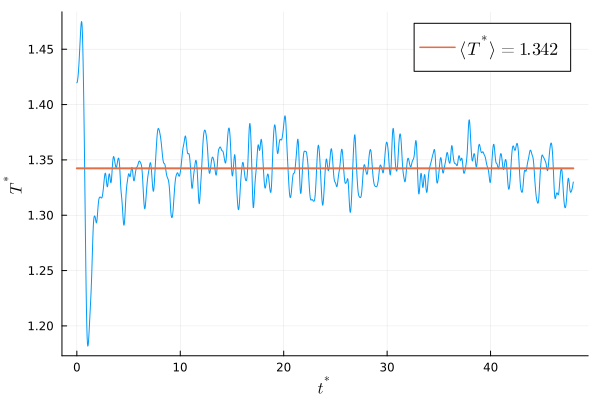

In [8]:
temperatures = [temperature(velocities) for velocities in velocity_history]
t = range(0, step=h, length=size(temperatures)[1]);

start = 55
μ = mean(temperatures[start:end])
average_temp = [μ for _ in range(1, length=size(temperatures)[1])]
μ = round(μ, digits=3)

temperature_plot = plot(t, temperatures, label=:none, xlabel="\$ t^{*} \$", ylabel="\$ T^{*}\$", legendfontsize=12)
plot!(t, average_temp, label="\$ \\langle T^{*}\\rangle = $μ \$", lw=2, dpi=600)

# savefig(temperature_plot, "temperature_plot.png")

# Part d)

## Letting the system evolve

In [4]:
T = 1.38
ρ = 0.55
t_final = 48.
book_keeping = true
rescaling = true

@time position_history, velocity_history = simulation(T, ρ, t_final, book_keeping, rescaling)

 25.996986 seconds (1.01 G allocations: 75.733 GiB, 16.81% gc time, 0.13% compilation time)


([[[1.9374586123029286e-8, 1.9374586123029286e-8, 1.9374586123029286e-8], [1.9374586123029285, 1.9374586123029286e-8, 1.9374586123029286e-8], [3.874917224605857, 1.9374586123029286e-8, 1.9374586123029286e-8], [5.812375836908785, 1.9374586123029286e-8, 1.9374586123029286e-8], [7.749834449211714, 1.9374586123029286e-8, 1.9374586123029286e-8], [9.687293061514643, 1.9374586123029286e-8, 1.9374586123029286e-8], [1.9374586123029286e-8, 1.9374586123029285, 1.9374586123029286e-8], [1.9374586123029285, 1.9374586123029285, 1.9374586123029286e-8], [3.874917224605857, 1.9374586123029285, 1.9374586123029286e-8], [5.812375836908785, 1.9374586123029285, 1.9374586123029286e-8]  …  [3.874917224605857, 8.718563755363178, 10.656022367666107], [5.812375836908785, 8.718563755363178, 10.656022367666107], [7.749834449211714, 8.718563755363178, 10.656022367666107], [9.687293061514643, 8.718563755363178, 10.656022367666107], [1.9374586123029286e-8, 10.656022367666107, 10.656022367666107], [1.9374586123029285, 

## Plotting the temperature

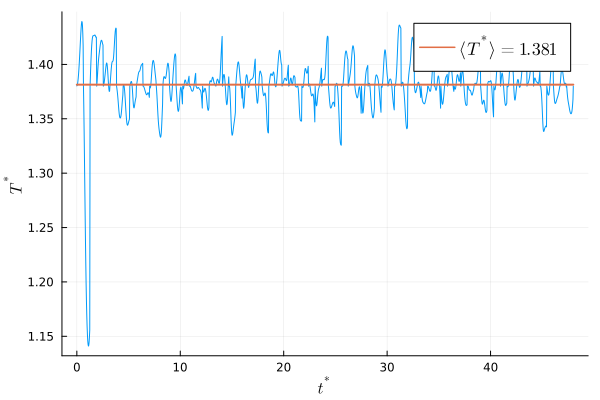

In [6]:
h=0.032
temperatures = [temperature(velocities) for velocities in velocity_history]
t = range(0, step=h, length=size(temperatures)[1]);

start = 55
μ = mean(temperatures[start:end])
average_temp = [μ for _ in range(1, length=size(temperatures)[1])]
μ = round(μ, digits=3)

temperature_plot2 = plot(t, temperatures, label=:none, xlabel="\$ t^{*} \$", ylabel="\$ T^{*}\$", legendfontsize=12)
plot!(t, average_temp, label="\$ \\langle T^{*}\\rangle = $μ \$", lw=2, dpi=600)

# savefig(temperature_plot2, "temperature_plot2.png")